# Predicting Premier League Scores
Can a neural network be used with team statistics from the 2021/22 Premier League season to predict results for the rest of the season?
## The Goal (get it?)
The goal of this project is to create a machine learning model that can be used to predict Premier League scores when given a specific matchup. Specifically, the model is tasked with determing the probability that each team scores a certain number of goals. Therefore, even though it doesn't output a specific score, we get an insight about what the score can possibly be.
## Dataset
The data were primarily taken from two sources. 

Team statistics (goals, fouls, penalties, etc.) were taken from the official Premier League website, specifically https://www.premierleague.com/stats/top/clubs where various stats are compiled for each club.

Match results were taken from https://www.football-data.co.uk/englandm.php. This page contains the results for every Premier League match played since the 1993/94 season. These are kept as CSV files separated by the season


### Importing Dependencies

In [1]:
# For loading and transforming data
import pandas as pd
import numpy as np

# Separates data into training and testing set
from sklearn.model_selection import train_test_split

# For plotting various data
import seaborn as sns
import matplotlib.pyplot as plt

# Needed for neural network modeling, training, and testing
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

### Retrieving Data and Feature Extraction

As mentioned before, team statistics were taken from the official Premier League website. Each available stat was complied in an spreadsheet, resulting in a table with 20 rows (1 per team) and 25 columns (1 per feature). Because there are so many features, it may be necessary to cut some of them out, as they may not contribute that much to the overall score.

In [2]:
# Retrieving team statistics
prem = pd.read_csv("Documents\PremStats.csv")
team_list = prem['Teams']

display(prem)

,Teams,Shots,ShotsTarget,Woodwork,GoalsHead,GoalsPen,GoalsFree,GoalsInBox,GoalsOutBox,GoalsCounter,...,Blocks,Intercept,Tackles,TacklesLastMan,Clearance,HeadClear,OwnGoals,PensFaced,PensConcede,Fouls
0,Arsenal,388,129,14,4,1,1,36,6,6,...,89,201,364,2,421,213,0,4,3,275
1,Aston Villa,317,106,3,5,2,0,35,6,3,...,103,245,456,0,452,209,1,6,3,344
2,Brentford,289,104,10,5,5,0,29,1,0,...,88,295,474,1,616,313,2,2,2,355
3,Brighton,338,103,10,7,3,0,21,5,0,...,98,261,492,0,483,252,1,3,2,332
4,Burnley,266,80,8,8,0,1,19,3,0,...,154,307,412,1,579,298,1,0,0,331
5,Chelsea,389,143,10,11,7,1,48,9,0,...,74,262,426,1,489,230,1,5,5,341
6,Crystal Palace,303,105,10,2,4,1,36,3,2,...,99,245,493,3,538,268,2,5,3,365
7,Everton,300,94,2,6,3,0,25,5,3,...,91,247,483,2,468,224,4,2,1,288
8,Leeds,378,116,13,2,4,1,22,7,0,...,114,294,546,0,428,191,1,5,5,403
9,Leicester,301,116,8,3,2,0,37,3,3,...,106,260,458,3,531,294,1,6,5,284


Before getting into feature extraction (removing unneeded features from the data), the data needs to be normalized. Some features have values that are much greater than others. For example, the number of goals is orders of magnitude greater than penalties conceded. This imbalance makes training the weights in the neural network very difficult, so it would be nice to transform these values so that they ALL fall in around the same range.

### The Z-Score 
In order to normalize the data, each column's data is subtracted by the column mean and then divided by the column standard deviation. This transformation basically tried to turn the data into a normal distribution with a mean of 0 and a standard deviation of 1. However, because this is a linear transformation for each column, the correlation and relationship between features is unchanged.

The Z- score is calculated as $\ Z = (X - \bar{X})/ \sigma $

In [3]:
# Make a list of the features 
cols = list(prem.columns)

# Compute the z_score for each velue
for col in cols[1:]:
    col_zscore = col + '_zscore'
    prem[col_zscore] = (prem[col] - prem[col].mean())/prem[col].std(ddof=0)
    prem = prem.drop(col, axis = 1)

display(prem)

,Teams,Shots_zscore,ShotsTarget_zscore,Woodwork_zscore,GoalsHead_zscore,GoalsPen_zscore,GoalsFree_zscore,GoalsInBox_zscore,GoalsOutBox_zscore,GoalsCounter_zscore,...,Blocks_zscore,Intercept_zscore,Tackles_zscore,TacklesLastMan_zscore,Clearance_zscore,HeadClear_zscore,OwnGoals_zscore,PensFaced_zscore,PensConcede_zscore,Fouls_zscore
0,Arsenal,0.565818,0.291108,1.502936,-0.689656,-1.063796,0.441836,0.223067,0.364854,2.331194,...,-0.451706,-1.992147,-1.781732,0.303774,-0.950036,-0.814129,-1.401770,0.088045,0.050063,-1.388976
1,Aston Villa,-0.449936,-0.465444,-1.836921,-0.326679,-0.503903,-0.820553,0.143400,0.364854,0.514679,...,0.125818,-0.660012,0.223398,-1.432078,-0.600468,-0.889424,-0.363422,0.968496,0.050063,-0.017884
2,Brentford,-0.850515,-0.531231,0.288442,-0.326679,1.175774,-0.820553,-0.334600,-1.781346,-1.301835,...,-0.492957,0.853777,0.615706,-0.564152,1.248861,1.068250,0.674926,-0.792406,-0.450564,0.200696
3,Brighton,-0.149502,-0.564124,0.288442,0.399275,0.055989,-0.820553,-0.971934,-0.064386,-1.301835,...,-0.080441,-0.175600,1.008013,-1.432078,-0.250900,-0.080001,-0.363422,-0.352180,-0.450564,-0.256335
4,Burnley,-1.179562,-1.320675,-0.318805,0.762252,-1.623688,0.441836,-1.131268,-0.922866,-1.301835,...,2.229653,1.217087,-0.735577,-0.564152,0.831634,0.785893,-0.363422,-1.672857,-1.451816,-0.276206
5,Chelsea,0.580124,0.751617,0.288442,1.851183,2.295559,0.441836,1.179068,1.652574,-1.301835,...,-1.070481,-0.145324,-0.430449,-0.564152,-0.183241,-0.494124,-0.363422,0.528271,1.051315,-0.077497
6,Crystal Palace,-0.650225,-0.498337,0.288442,-1.415610,0.615882,0.441836,0.223067,-0.922866,-0.090826,...,-0.039189,-0.660012,1.029808,1.171700,0.369302,0.221180,0.674926,0.528271,0.050063,0.399405
7,Everton,-0.693145,-0.860166,-2.140545,0.036298,0.055989,-0.820553,-0.653267,-0.064386,0.514679,...,-0.369202,-0.599461,0.811860,0.303774,-0.420046,-0.607067,2.751623,-0.792406,-0.951190,-1.130654
8,Leeds,0.422754,-0.136508,1.199312,-1.415610,0.615882,0.441836,-0.892267,0.794094,-1.301835,...,0.579586,0.823502,2.184937,-1.432078,-0.871102,-1.228252,-0.363422,0.528271,1.051315,1.154499
9,Leicester,-0.678838,-0.136508,-0.318805,-1.052633,-0.503903,-0.820553,0.302734,-0.922866,0.514679,...,0.249573,-0.205875,0.266987,1.171700,0.290367,0.710598,-0.363422,0.968496,1.051315,-1.210138


### Correlation Matrix
With this many features, a correlation matrix can be used to see how each feature relates with the others. The correlation values range from -1 to 1, with correlations farther from 0 indicating more correlated data. For feature extraction, if there are two features that have a high correlation (absolute value > 0.9), one of them can be dropped from the data. Having multiple features that are highly correlated is kind of redundant, so one of them can be dropped.

If there aren't any highly correlated features, some can be dropped just based on how important you think they are to the dependent variable (score in this case).

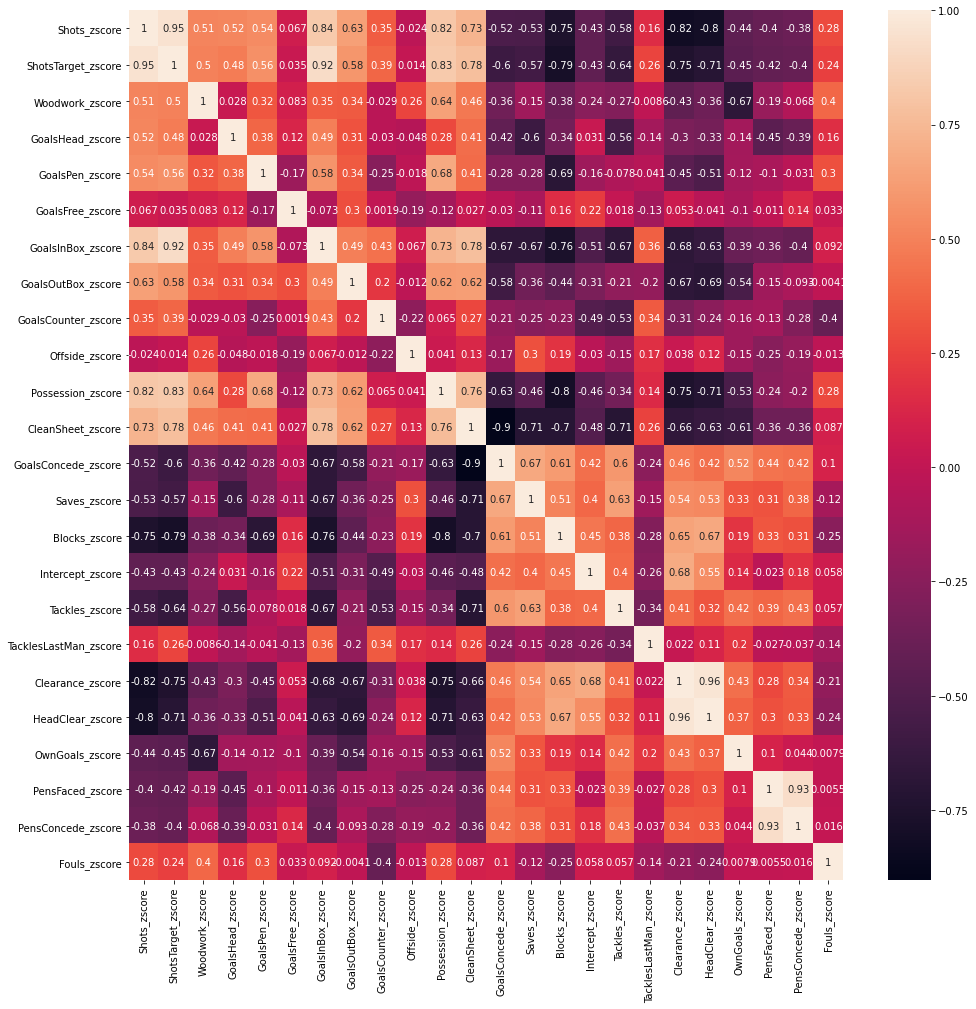

In [4]:
# Get rid of the 'Teams' column, leaving only numerical values
stats_noteam = prem.iloc[:,1:]

# Calculate and plot correlation matrix
correlation_mat = stats_noteam.corr()
plt.figure(figsize = (16,16))
sns.heatmap(correlation_mat, annot = True)
plt.show()

##### High Correlation Pairs: 
* Shots vs Shots on Target (0.95)

* Shots on Target vs Goals fron In Box (0.92)

* Penalties Faced vs Penalties Conceded (0.93) 

* Clean Sheets vs Goals Conceded (-0.9)
                        
At most, 4 out of the 24 total features can be removed using the above criterion. I dont think this reduction is enough, so the data can remain as is (with all 24 features) or reduced in a different way. 

### Principal Components Analysis 

The principal components analysis (PCA) is a statistical method that can be used to reduce high-dimensional (feature) data. To perform the PCA: 
1. Reorganize the data so that each feature has its own row (each column represents a separate data point)
2. Standardize the feature values by subtracting each value by the feature mean. (This was already done)
    * It might be helpful to divide by the standard deviation as well, as was done above, in order to keep all data in the same range
3. Perform the singular value decomposition (SVD) on the data.

The SVD takes the data, represented as a matrix, and breaks it up into three separate ones, as shown below:
![Singular Value Decomposition](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Reduced_Singular_Value_Decompositions.svg/320px-Reduced_Singular_Value_Decompositions.svg.png)

The diagonal matrix Σ shows the singular values, and can be used to reconstruct a truncated version of the original data. For this data, since the correlation matrix showed a clear separation between attack and defensive stats, two matrices were made corresponding to both. The SVD of each would be taken, giving an offensive truncated matrix and a defensive truncated matrix.

In [5]:
# Putting features in the rows
stats_noteam = stats_noteam.T

# Splitting original data into attack and defense statistics
prem_off= stats_noteam.iloc[0:11].to_numpy(dtype = float) # Attack (offensive) stats
print(np.shape(prem_off)) # 20 columns for 20 teams

#Defensive stats
prem_def= stats_noteam.iloc[11:].to_numpy(dtype = float) # Defensive stats
print(np.shape(prem_def))

(11, 20)
(13, 20)


Creating the truncated matrix involves looking at the Σ and U matrices.First, by taking the cumulative sum of the singular values at a row/column n and then dividing by the sum ao all the singular values, one can essentially measure the accuracy of the following truncation. Afterwards, the corresponding columns are kept in the U matrix, with everything else dropped.

For example, if 90% of the original data can be captured with the first 4 singular values of a 7x7 Σ matrix, the first 4 columns of U are kept to make a new truncated U.

Another example, if for some you, you want to truncate the data based on the first, third, and seventh singular values, you would only keep the first, third, and seventh columns of the U matrix.

Getting the approximation of the original data is as simple recasting the original data into the coordinate system of the U matrix. This is just matrix multiplication involving the original data matrix and the truncated U matrix. These coordinated will be the inputs of the neural network.

In [6]:
U_a,S_a,VT_a = np.linalg.svd(prem_off, full_matrices = 0) # Perform SVD
attack = prem_off.T @ U_a[0:8].T # Reconstruct matrix using first 8 singular values

U_d,S_d,VT_d = np.linalg.svd(prem_def, full_matrices = 0)
defense = prem_def.T @ U_d[0:8].T

print('Attack SVD w/ 8 SV: ' ,sum(S_a[0:8])/sum(S_a)) # Check 'accuracy' of new matrix
print('Defense SVD w/ 8 SV: ',sum(S_d[0:8])/sum(S_d))
print('Attack SVD w/ 3 SV: ' ,sum(S_a[0:3])/sum(S_a)) # For the plots below
print('Defense SVD w/ 3 SV: ',sum(S_d[0:3])/sum(S_d))

Attack SVD w/ 8 SV:  0.925258021671071
Defense SVD w/ 8 SV:  0.8779001340374873
Attack SVD w/ 3 SV:  0.512221343503143
Defense SVD w/ 3 SV:  0.4806502178773324


In [7]:
np.shape(prem_off)

(11, 20)

### Plotting Attacking Coordinates

<IPython.core.display.Javascript object>


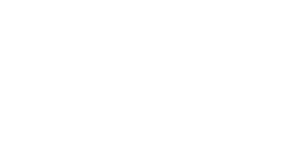

In [8]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

plt.ion()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


for i in range(20):
    ax.scatter(attack[i][0],attack[i][1],attack[i][2])
    ax.text3D(attack[i][0],attack[i][1],attack[i][2],team_list[i])


ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

plt.show()

### Plotting Defensive Coordinates

<IPython.core.display.Javascript object>


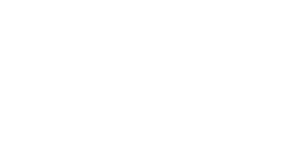

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


for i in range(20):
    ax.scatter(defense[i][0],defense[i][1],defense[i][2])
    ax.text3D(defense[i][0],defense[i][1],defense[i][2],team_list[i])


ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

plt.show()

In [10]:
# Create a new dataframe relating team to new coordinates
att_param = {team_list[n]:attack[n] for n in range(20)}
att_df = pd.DataFrame(data=att_param)
def_param = {team_list[n]:defense[n] for n in range(20)}
def_df = pd.DataFrame(data=def_param)

# Load matchup and results data (Taken as of March 11, 2022)
prem_results = pd.read_csv("Documents\PremState_031122.csv")
prem_results = prem_results[['HomeTeam','AwayTeam','FTHG','FTAG']]

# display(att_df)
# display(def_df)
display(prem_results)

,HomeTeam,AwayTeam,FTHG,FTAG
0,Brentford,Arsenal,2,0
1,Man United,Leeds,5,1
2,Burnley,Brighton,1,2
3,Chelsea,Crystal Palace,3,0
4,Everton,Southampton,3,1
...,...,...,...,...
266,Tottenham,Everton,5,0
267,Norwich,Chelsea,1,3
268,Southampton,Newcastle,1,2
269,Wolves,Watford,4,0


## Neural Network

With the data preprocessing done, the neural network can start to be modelled.
The general idea is that the inputs that the neural network takes in are the attack and defense coordinates from each team and it outputs 2 probability distribution relating to goals scored for each team. The idea is for one of the inputs to be a vector concatenates the home team's attack coordinates with the away team's defense coordinates and the other input to be a similar vector that concatenates the home team's defense coordinates with the away team's attack coordinaters. Therefore, the neural network will 2 inputs, two outputs, and a kind of elongated X shape.

In [11]:
# These functions concatenate the coordinates of the home and away teams, as described above

# Concatenates home team attack to away team defense
def homea_to_awayd(home,away):
    homea_to_awayd = pd.concat([att_df[home], def_df[away]], ignore_index=True)
    return homea_to_awayd.tolist()

# Concatenates home team defense to away team attack
def homed_to_awaya(home,away):
    homed_to_awaya = pd.concat([def_df[home], att_df[away]], ignore_index=True)
    return homed_to_awaya.tolist()

In [79]:
# Splits the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(prem_results[['HomeTeam','AwayTeam']], 
                                                    prem_results[['FTHG','FTAG']], 
                                                    test_size=0.20)

# Changes team matchups into concatenated coordinate vectors 
X_train = X_train.to_numpy()
train_input1 = np.asarray([homea_to_awayd(X_train[i][0],X_train[i][1]) for i in range(len(X_train))])
train_input2 = np.asarray([homed_to_awaya(X_train[i][0],X_train[i][1]) for i in range(len(X_train))])

X_test = X_test.to_numpy()
test_input1 = np.asarray([homea_to_awayd(X_test[i][0],X_test[i][1]) for i in range(len(X_test))])
test_input2 = np.asarray([homed_to_awaya(X_test[i][0],X_test[i][1]) for i in range(len(X_test))])

# Separates scores based on home or away side
y_train1 = y_train['FTHG'].to_numpy(dtype=np.float32) # Home
y_train2 = y_train['FTAG'].to_numpy(dtype=np.float32) # Away
y_test1 = y_test['FTHG'].to_numpy(dtype=np.float32) # Home
y_test2 = y_test['FTAG'].to_numpy(dtype=np.float32) # Away

# print(X_train,'\n')
# print(train_input1)


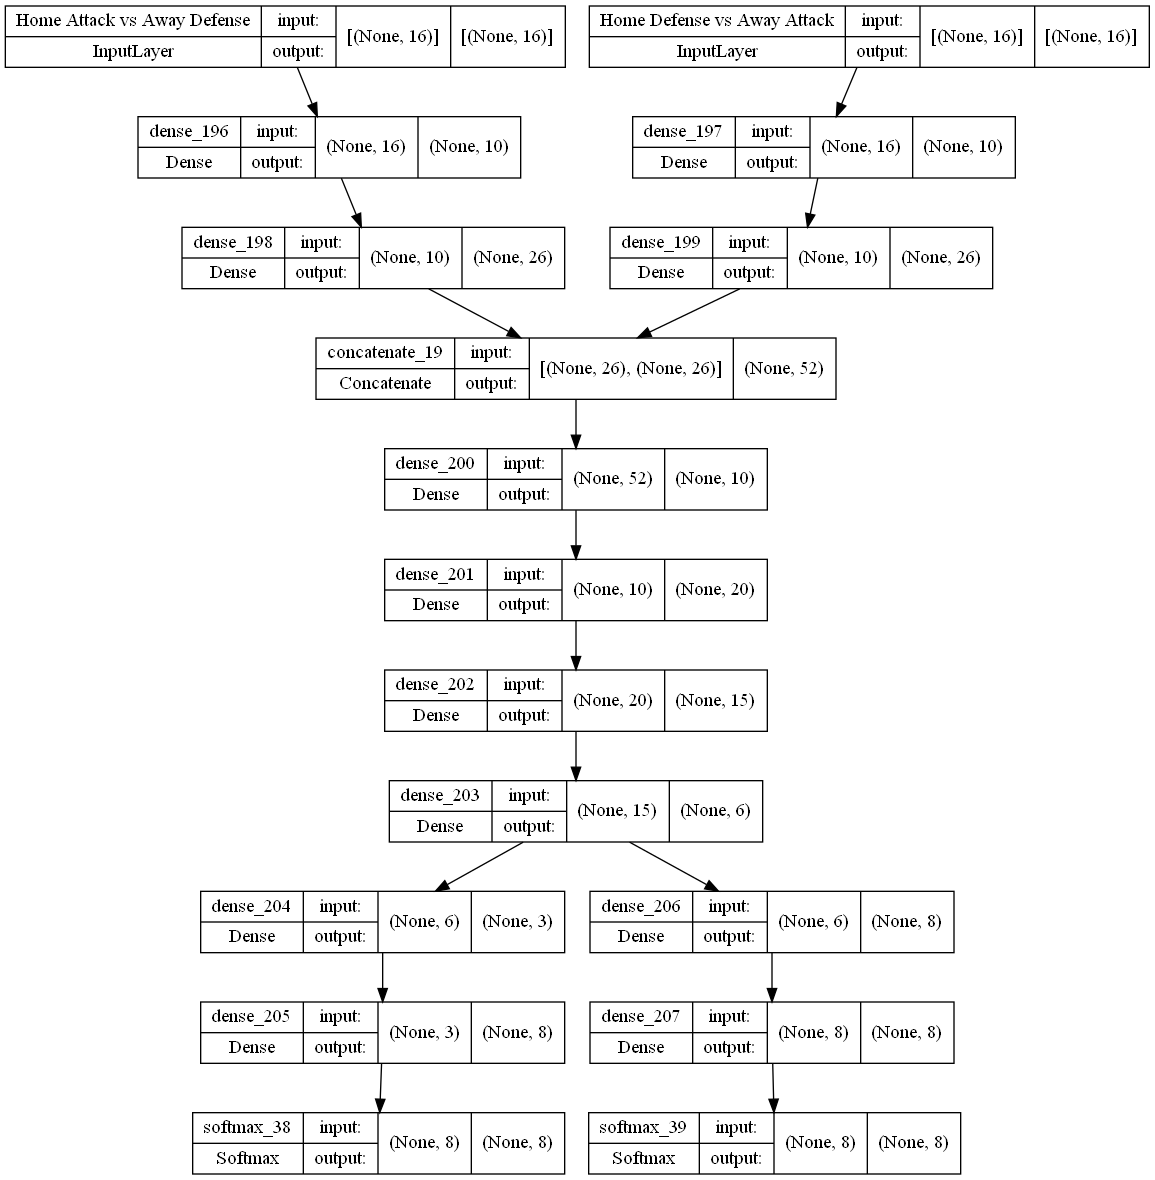

In [95]:
# Describe neural network architecture
input_1 = keras.Input(shape=(16,), name="Home Attack vs Away Defense") 
input_2 = keras.Input(shape=(16,), name="Home Defense vs Away Attack")

x = layers.Dense(10, activation = 'relu')(input_1)
y = layers.Dense(10, activation = 'relu')(input_2)

x = layers.Dense(26, activation = 'relu')(x)
y = layers.Dense(26, activation = 'relu')(y)

shared_layer = layers.concatenate([x, y])

z = layers.Dense(10, activation = 'elu')(shared_layer)

z = layers.Dense(20, activation = 'elu')(z)

z = layers.Dense(15, activation = 'elu')(z)

z = layers.Dense(6, activation = 'elu')(z)

z1 = layers.Dense(3, activation = 'selu')(z)
z1 = layers.Dense(8)(z1)
z1 = tf.keras.layers.Softmax()(z1)

z2 = layers.Dense(8, activation = 'selu')(z)
z2 = layers.Dense(8)(z2)
z2 = tf.keras.layers.Softmax()(z2)

# Create model based on above 
predict_model = keras.Model(
    inputs=[input_1, input_2],
    outputs=[z1,z2]
)

# Initialize optimization algorithm and loss function
predict_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.RMSprop()
) 

from tensorflow.keras.utils import plot_model
plot_model(predict_model, to_file='model.png', show_shapes=True)

The rationale behind this neural network structure is that one can predict how many goals a tea, will score just by comparing the attack of one team to the defense of the other and vice versa. That is why there are two separate input vectors that go through the start of the network independent of each other. Eventually, after two dense layers, the vectors are concatenated. Of course, a team's attack is not independent of its defense and the number of goals scored by each team are not independent of each other. That is why the middle portion 'mixes' the two vectors together to deliver a final output. The middle section splits up into two paths, with the final output relating to the goal probability distributions for each team.

### Training

Epoch 1/5
151/151 - 2s - loss: 3.5933 - softmax_38_loss: 1.8530 - softmax_39_loss: 1.7402 - val_loss: 3.5039 - val_softmax_38_loss: 1.8110 - val_softmax_39_loss: 1.6929 - 2s/epoch - 10ms/step
Epoch 2/5
151/151 - 0s - loss: 3.2332 - softmax_38_loss: 1.6719 - softmax_39_loss: 1.5613 - val_loss: 3.3434 - val_softmax_38_loss: 1.7422 - val_softmax_39_loss: 1.6012 - 278ms/epoch - 2ms/step
Epoch 3/5
151/151 - 0s - loss: 3.0813 - softmax_38_loss: 1.5804 - softmax_39_loss: 1.5009 - val_loss: 3.2452 - val_softmax_38_loss: 1.7002 - val_softmax_39_loss: 1.5449 - 255ms/epoch - 2ms/step
Epoch 4/5
151/151 - 0s - loss: 2.9771 - softmax_38_loss: 1.5311 - softmax_39_loss: 1.4460 - val_loss: 3.1544 - val_softmax_38_loss: 1.6737 - val_softmax_39_loss: 1.4807 - 262ms/epoch - 2ms/step
Epoch 5/5
151/151 - 0s - loss: 2.9014 - softmax_38_loss: 1.5013 - softmax_39_loss: 1.4001 - val_loss: 3.1797 - val_softmax_38_loss: 1.6637 - val_softmax_39_loss: 1.5160 - 272ms/epoch - 2ms/step


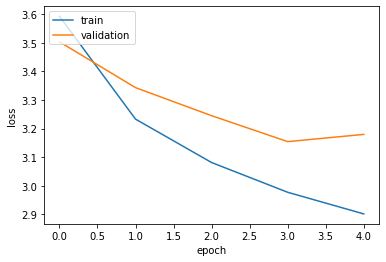

In [96]:
# Training model
history = predict_model.fit([train_input1,train_input2], [y_train1,y_train2], batch_size=1, epochs=5, validation_split=0.3,shuffle=True, verbose = 2)

# Plots traing and validation loss for each epoch
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

I determine how many epochs to train with based how the losses change over time. The training loss will almost always decrease with more epochs but the validation loss might start to increase after a certain point. The point where it starts to increase is where I would cut the training short as to avoid overfitting the model. It is important to avoid overfitting becasue the model will not be useful if it cannot generalize beyond the training set.

After training, I evaluate the model on the testing set and make sure that the loss on that is good. The lowest I've seen was arond 2.8, but most of the time the loss for the testing set will be around 3.1. 

In [97]:
# Evaluating the loss from the testing data set. 
results = predict_model.evaluate([test_input1,test_input2], [y_test1,y_test2])
print("Test Loss: ", results[0])

2/2 [==============================] - 0s 4ms/step - loss: 3.1075 - softmax_38_loss: 1.5609 - softmax_39_loss: 1.5466
Test Loss:  3.1074836254119873


## Using the Model for Prediction

In [16]:
def predict_score(home,away):
    input1 = np.asarray([homea_to_awayd(home,away)])
    input2 = np.asarray([homed_to_awaya(home,away)])
    return predict_model.predict([input1,input2]) 

Text(0.5, 1.0, 'Arsenal')

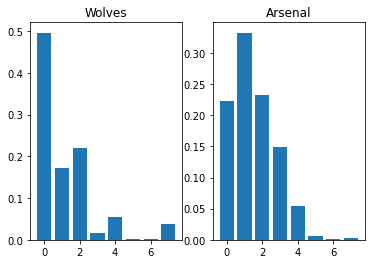

In [100]:
%matplotlib inline
plt.ioff()
#for team in team_list:
home = 'Wolves'
away = 'Arsenal'
array = predict_score(home,away)

# Plot home team goal distribution
plt.figure()
plt.subplot(121)
plt.bar([0,1,2,3,4,5,6,7],array[0].flatten())
plt.title(home)

# Plot away team goal distribution
plt.subplot(122)
plt.bar([0,1,2,3,4,5,6,7],array[1].flatten())
plt.title(away)